<a href="https://colab.research.google.com/github/tripsysi/Wine_Classifier/blob/main/DATA7703_Project_Wine_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA7703 Project  - Wine Classifier

In [418]:
####################
import numpy as np
from numpy import where
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, mean_squared_error
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

from collections import Counter

## Read in data

In [352]:
redwine = pd.read_csv("https://raw.githubusercontent.com/tripsysi/Wine_Classifier/main/data/winequality-red.csv")
whitewine = pd.read_csv("https://raw.githubusercontent.com/tripsysi/Wine_Classifier/main/data/winequality-white.csv")

Citation : Data from https://archive.ics.uci.edu/ml/datasets/wine+quality

In [353]:
redwine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [354]:
print(redwine.shape)
print(whitewine.shape)

(1599, 12)
(4898, 12)


## Preprocessing

### Preliminary EDA

#### Class Distributions in percentages

In [355]:
redwine['quality'].value_counts(normalize=True)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [356]:
whitewine['quality'].value_counts(normalize=True)

6    0.448755
5    0.297468
7    0.179665
8    0.035729
4    0.033279
3    0.004083
9    0.001021
Name: quality, dtype: float64

#### Visualisation of the class distributions using PCA

Quality 7, 8, 9 are considered good <br>
5, 6 are average <br>
rest poor quality

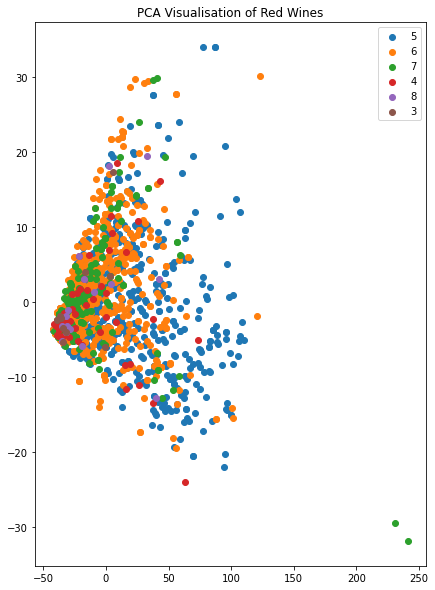

In [357]:
counter = Counter(redwine['quality'])
pca = PCA(n_components=2)
red_rwine = pca.fit_transform(redwine)
for label, _ in counter.items():
    row_ix = where(redwine['quality'] == label)[0]
    plt.scatter(red_rwine[row_ix, 0], red_rwine[row_ix, 1], label=str(label))
plt.legend()
plt.title("PCA Visualisation of Red Wines")
plt.show()

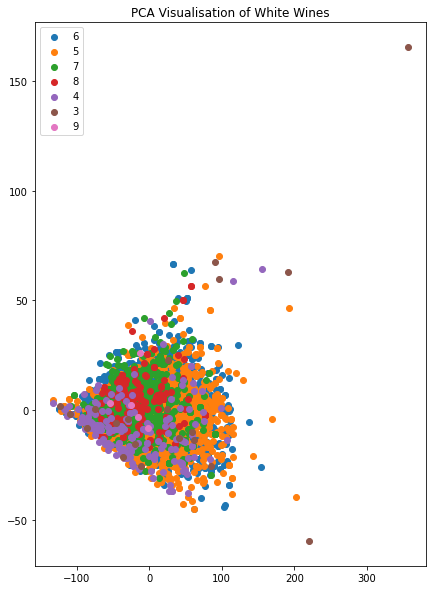

In [358]:
counter = Counter(whitewine['quality'])
pca = PCA(n_components=2)
red_wwine = pca.fit_transform(whitewine)
for label, _ in counter.items():
    row_ix = where(whitewine['quality'] == label)[0]
    plt.scatter(red_wwine[row_ix, 0], red_wwine[row_ix, 1], label=str(label))
plt.legend()
plt.title("PCA Visualisation of White Wines")
plt.show()

#### Correlations

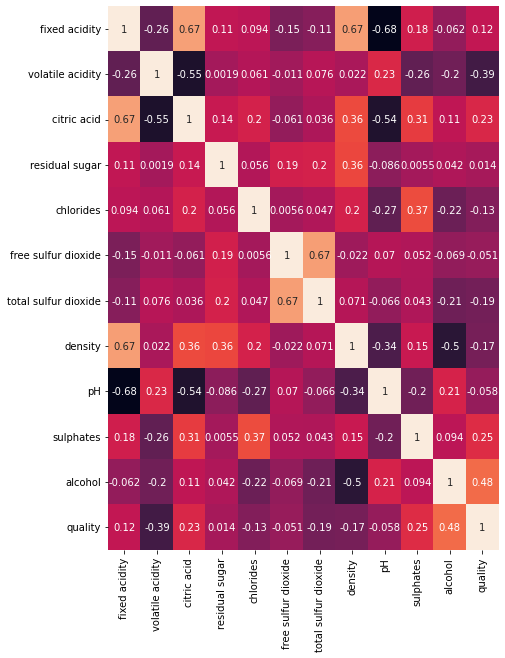

In [359]:
sns.heatmap(redwine.corr(), annot=True, cbar=False);

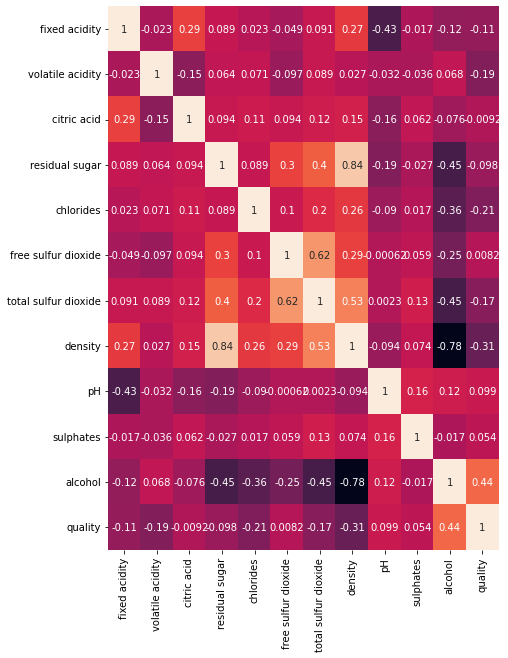

In [360]:
sns.heatmap(whitewine.corr(), annot=True, cbar=False);

Alcohol, sulphates and citric acid most correlated to quality of red wine. While for white wine, alcohol, lightness (negative correlation to density) and lack of chlorides is most related to resultant quality

### Merging Wine tables 

In [361]:
redwine.insert(11, 'Winetype', 0)
whitewine.insert(11, 'Winetype', 1)

In [362]:
print(redwine.shape)
print(whitewine.shape)

(1599, 13)
(4898, 13)


In [363]:
wines = pd.concat([redwine,whitewine])
wines.shape

(6497, 13)

In [364]:
wines.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
Winetype                0
quality                 0
dtype: int64

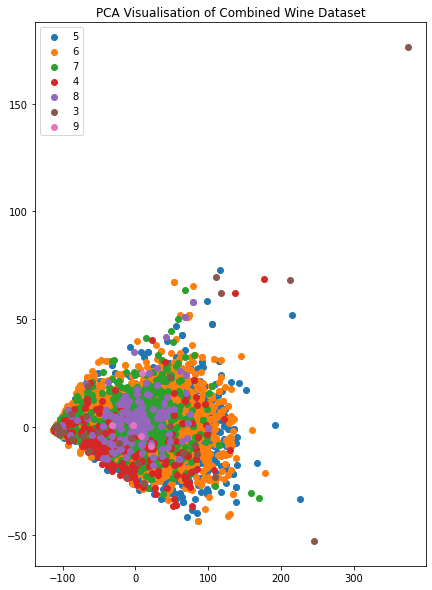

In [365]:
counter = Counter(wines['quality'])
pca = PCA(n_components=2)
wines_pca = pca.fit_transform(wines)
for label, _ in counter.items():
    row_ix = where(wines['quality'] == label)[0]
    plt.scatter(wines_pca[row_ix, 0], wines_pca[row_ix, 1], label=str(label))
plt.legend()
plt.title("PCA Visualisation of Combined Wine Dataset")
plt.show()

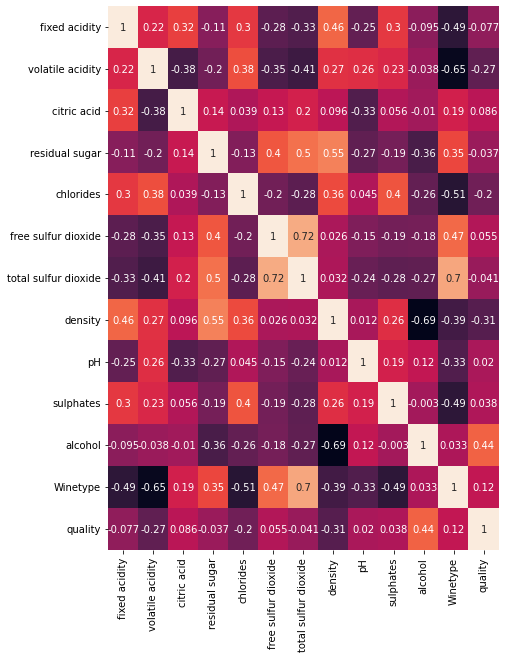

In [366]:
sns.heatmap(wines.corr(), annot=True, cbar=False);

### Wine quality buckets

Set wine quality to high, med, low: <br>
Low for less or equal to 5. Set to 0 <br>
Medium between 6 and 7. Set to 1 <br>
High for more then 7. Set to 2

In [367]:
wines['quality_label'] = wines.quality.apply(lambda x: 0 if x <= 5 \
                                             else 1 \
                                             if x <= 7 else 2)

In [368]:
wines['quality_label'].value_counts() # Still pretty unbalanced but usable

1    3915
0    2384
2     198
Name: quality_label, dtype: int64

In [369]:
wines.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'Winetype', 'quality', 'quality_label'],
      dtype='object')

Visualisation by wine quality in buckets

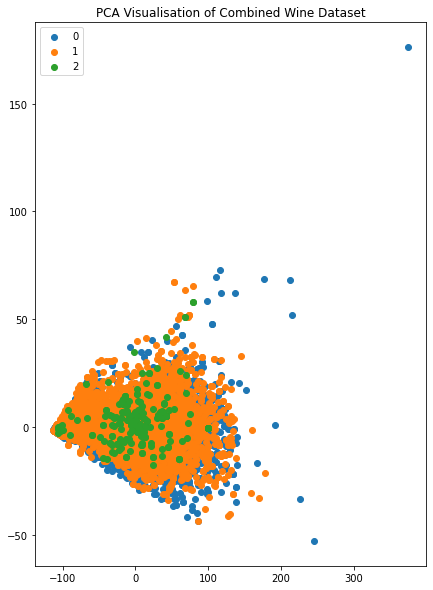

In [370]:
counter = Counter(wines['quality_label'])
pca = PCA(n_components=2)
wines_pca = pca.fit_transform(wines)
for label, _ in counter.items():
    row_ix = where(wines['quality_label'] == label)[0]
    plt.scatter(wines_pca[row_ix, 0], wines_pca[row_ix, 1], label=str(label))
plt.legend()
plt.title("PCA Visualisation of Combined Wine Dataset")
plt.show()

Low quality wines are outliers mainly

### Normalizing data

In [371]:
X = wines.iloc[: , :-1]
y = wines.iloc[:,-1:]

In [372]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### Splitting into Train Test sets

In [373]:
from sklearn.model_selection import train_test_split

In [374]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=20)

In [375]:
X_train.shape #check

(5847, 13)

In [376]:
X_test.shape

(650, 13)

In [377]:
y_train.shape

(5847, 1)

In [378]:
y_test.shape

(650, 1)

## Modelling

### Knn

With Standard knn on all types of data.
As per literature, the optimal K value usually found is the square root of N, where N is the total number of samples

In [379]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scoring = {'accuracy' : make_scorer(accuracy_score),
           'f1_score' : make_scorer(f1_score, average='macro')}

In [380]:
knn_clf = KNeighborsClassifier()

In [381]:
knn_clf.fit(X_train,np.ravel(y_train))

KNeighborsClassifier()

In [382]:
cv_scores = cross_validate(knn_clf, X_train, np.ravel(y_train), cv=cv)

In [383]:
print("Mean Cross validation Scores", np.mean(cv_scores['test_score']))

Mean Cross validation Scores 0.9914491862779535


In [384]:
cv_scores

{'fit_time': array([0.00795841, 0.0066731 , 0.01347256, 0.00611472, 0.00617313,
        0.00613213, 0.01173735, 0.00871921, 0.00613236, 0.00613809]),
 'score_time': array([0.02834773, 0.03005338, 0.03590512, 0.0293889 , 0.02863789,
        0.03401709, 0.02912164, 0.03109932, 0.03262258, 0.03051877]),
 'test_score': array([0.99145299, 0.98803419, 0.98803419, 0.99145299, 0.9982906 ,
        0.99145299, 0.98803419, 0.99486301, 0.98972603, 0.99315068])}

Hyperparameter Tuning

In [385]:
param_grid = {'n_neighbors': list(range(3,50,2)),
              'weights':['uniform', 'distance']
              }

In [386]:
f1_sc = make_scorer(f1_score, average='micro')

In [387]:
grid_knn_estimator = model_selection.GridSearchCV(knn_clf,
                                                 param_grid,
                                                 scoring=f1_sc,
                                                 refit=True,
                                                 cv=3,
                                                 return_train_score=True)

In [388]:
knn_model = grid_knn_estimator.fit(X_train,np.ravel(y_train))

In [389]:
print('Optimum parameters', knn_model.best_params_)

Optimum parameters {'n_neighbors': 7, 'weights': 'distance'}


#### Parameter selection graphs and tables

In [390]:
n_neighborss = list(range(3,27,2))

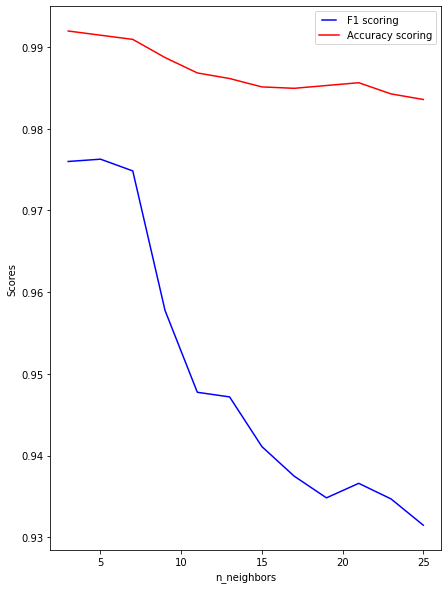

In [391]:
f1_results = []
accuracy_results = []
#roc_auc_results = []

for n_neighbors in n_neighborss:
    knn = KNeighborsClassifier(n_neighbors = n_neighbors)
    knn.fit(X_train, np.ravel(y_train))
    f1_scores = cross_val_score(knn, X_train, np.ravel(y_train), cv=cv, scoring = 'f1_macro')
    accuracy_scores = cross_val_score(knn, X_train, np.ravel(y_train), cv=cv, scoring = 'accuracy')
    #roc_auc_scores = cross_val_score(knn, X_train, np.ravel(y_train), cv=cv, scoring = 'roc_auc')
    f1_results.append(np.mean(f1_scores))
    accuracy_results.append(np.mean(accuracy_scores))
    #roc_auc_results.append(np.mean(roc_auc_scores))
  
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_neighborss, f1_results, 'b', label="F1 scoring")
line2, = plt.plot(n_neighborss, accuracy_results, 'r', label="Accuracy scoring")
#line3, = plt.plot(n_neighborss, roc_auc_results, 'g', label="ROC AUC scoring")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Scores')
plt.xlabel('n_neighbors')
plt.show()

Training with optimum parameters

In [392]:
knn_clf = KNeighborsClassifier(n_neighbors= 7,
                               weights = 'distance'
                              )

In [393]:
knn_clf.fit(X_train, np.ravel(y_train))

KNeighborsClassifier(n_neighbors=7, weights='distance')

In [394]:
cv_scores = cross_validate(knn_clf, X_train, np.ravel(y_train), cv=cv, scoring = scoring)

In [395]:
print("Mean Cross validation Scores after Hyperparameter Tuning|", np.mean(cv_scores['test_f1_score']))

Mean Cross validation Scores after Hyperparameter Tuning| 0.9824335900614667


On the test set

In [396]:
y_train_pred_knn = knn_clf.predict(X_train)
y_test_pred_knn = knn_clf.predict(X_test)

Model Score

In [397]:
print("Score for Training set",knn_clf.score(X_train, y_train))
print("Score for Testing set",knn_clf.score(X_test, y_test))

Score for Training set 1.0
Score for Testing set 0.9907692307692307


Getting the confusion matrix for prediction on the test set

In [398]:
confusion_matrix(y_test, y_test_pred_knn)

array([[236,   2,   0],
       [  0, 392,   0],
       [  0,   4,  16]])

In [399]:
print(classification_report(y_test, y_test_pred_knn))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       238
           1       0.98      1.00      0.99       392
           2       1.00      0.80      0.89        20

    accuracy                           0.99       650
   macro avg       0.99      0.93      0.96       650
weighted avg       0.99      0.99      0.99       650



Note to self: Oversample underrepresented classes ASAP
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

### Naïve Bayes

In [400]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score

In [401]:
nb_clf = GaussianNB()

In [402]:
nb_clf.fit(X_train,np.ravel(y_train))

GaussianNB()

In [403]:
# Predict
y_nb_train_pred = nb_clf.predict(X_train)
y_nb_test_pred = nb_clf.predict(X_test)
# Print accuracy
print("score for Training set",nb_clf.score(X_train, y_train))
print("score for Testing set",nb_clf.score(X_test, y_test))
#print(y_nb_test_pred)

score for Training set 0.9722934838378656
score for Testing set 0.9753846153846154


Classification Report for NB

In [404]:
print(classification_report(y_test, y_nb_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       238
           1       0.98      0.98      0.98       392
           2       1.00      0.80      0.89        20

    accuracy                           0.98       650
   macro avg       0.98      0.92      0.95       650
weighted avg       0.98      0.98      0.98       650



### SVM

In [405]:
from sklearn.svm import SVC, SVR

In [406]:
svm_clf = SVC()
svm_clf.fit(X_train, np.ravel(y_train))

SVC()

In [407]:
y_svm_test_pred = svm_clf.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_svm_test_pred))
print('Score', svm_clf.score(X_test, y_test))
print(classification_report(y_test, y_svm_test_pred))

Mean Squared Error: 0.0015384615384615385
Score 0.9984615384615385
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      1.00      1.00       392
           2       1.00      0.95      0.97        20

    accuracy                           1.00       650
   macro avg       1.00      0.98      0.99       650
weighted avg       1.00      1.00      1.00       650



### Random Forest

In [408]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [409]:
rf_clf = RandomForestClassifier(n_estimators=100,random_state=20)
rf_clf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=20)

In [410]:
y_rf_test_pred = rf_clf.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_rf_test_pred))
print('Score', rf_clf.score(X_test, y_test))
#print(y_rf_test_pred)

Mean Squared Error: 0.0015384615384615385
Score 0.9984615384615385


In [411]:
print(classification_report(y_test, y_rf_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      1.00      1.00       392
           2       1.00      0.95      0.97        20

    accuracy                           1.00       650
   macro avg       1.00      0.98      0.99       650
weighted avg       1.00      1.00      1.00       650



Look at implementing balanced Random Forest
 https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb

### Voting Classifier with knn, svm, rf, nb

Look at putting in a voting classifier ensemble and a plot of how ensemble performs better 
https://machinelearningmastery.com/bagging-ensemble-with-different-data-transformations/

In [412]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [413]:
clf1 = SVC()
clf2 = RandomForestClassifier(n_estimators=100, random_state=1)
clf3 = KNeighborsClassifier(n_neighbors=7, weights='distance')
clf4 = GaussianNB()
eclf = VotingClassifier(
    estimators=[('svc', clf1), ('rf', clf2), ('knn', clf3), ('nb', clf4)], voting='hard'#, weights=[1,2,2]
    )

In [414]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [425]:

accuracy_results = list()
f1_results = list()
mse_result = list()
for clf, label in zip([clf1, clf2, clf3, clf4, eclf], ['Support Vector Classification', 'Random Forest', 'Knn', 'Naive Bayes','Ensemble']):
    scores = cross_val_score(clf, X_train, np.ravel(y_train.values), scoring='accuracy', cv=cv)
    f1_scores = cross_val_score(clf, X_train, np.ravel(y_train.values), scoring='f1_macro', cv=cv)
    mse_scores = cross_val_score(clf, X_train, np.ravel(y_train.values), cv = cv, scoring='neg_mean_squared_error')
    accuracy_results.append(scores)
    f1_results.append(f1_scores)
    mse_result.append(mse_scores)
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    clf.fit(X_train,np.ravel(y_train.values))
    print("Classification Report \n", classification_report(y_test, clf.predict(X_test),\
                                                            labels = np.unique(clf.predict(X_test))))

Cross Validation Accuracy: 1.00 (+/- 0.00) [Support Vector Classification]
Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      1.00      1.00       392
           2       1.00      0.95      0.97        20

    accuracy                           1.00       650
   macro avg       1.00      0.98      0.99       650
weighted avg       1.00      1.00      1.00       650

Cross Validation Accuracy: 1.00 (+/- 0.00) [Random Forest]
Classification Report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      1.00      1.00       392
           2       1.00      1.00      1.00        20

    accuracy                           1.00       650
   macro avg       1.00      1.00      1.00       650
weighted avg       1.00      1.00      1.00       650

Cross Validation Accuracy: 0.99 (+/- 0.00) [Knn]
Classif

## Performance of various classifiers

### Accuracy Performance

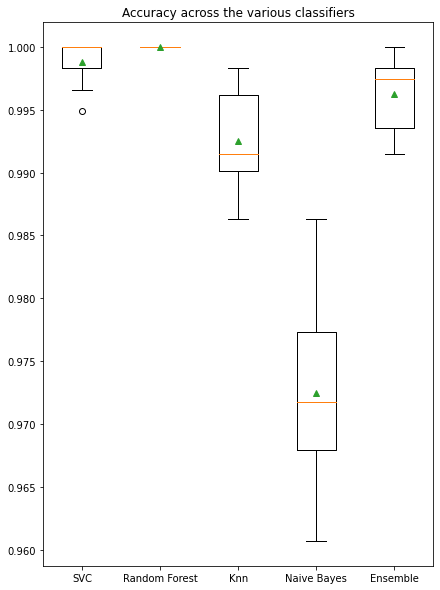

In [416]:
plt.rcParams['figure.figsize'] = (7, 10)
plt.boxplot(accuracy_results, labels=[n for n in (['SVC', 'Random Forest', 'Knn', 'Naive Bayes','Ensemble'] )], showmeans=True)
plt.title("Accuracy across the various classifiers")
plt.show()

### F1 Scores

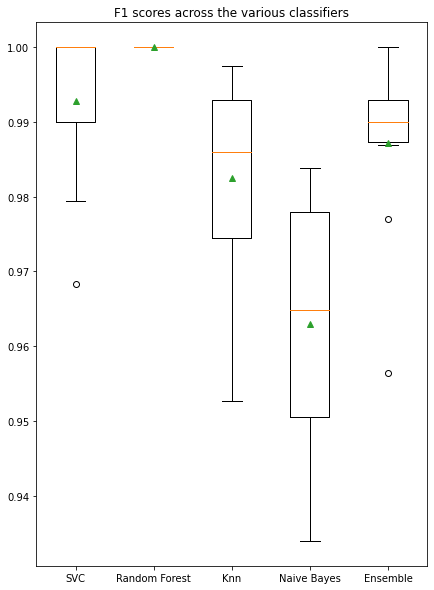

In [417]:
plt.rcParams['figure.figsize'] = (7, 10)
plt.boxplot(f1_results, labels=[n for n in (['SVC', 'Random Forest', 'Knn', 'Naive Bayes','Ensemble'] )], showmeans=True)
plt.title("F1 scores across the various classifiers")
plt.show()

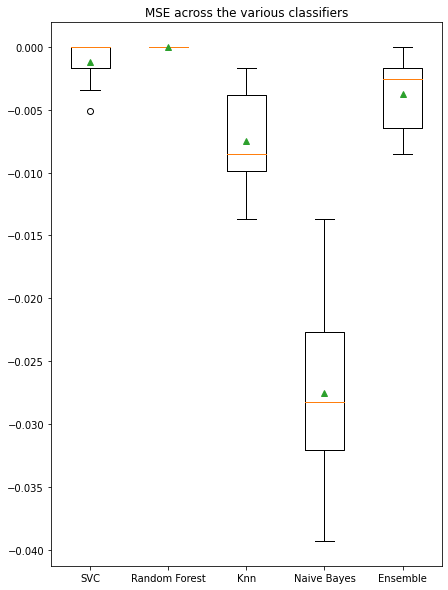

In [426]:
plt.rcParams['figure.figsize'] = (7, 10)
plt.boxplot(mse_result, labels=[n for n in (['SVC', 'Random Forest', 'Knn', 'Naive Bayes','Ensemble'] )], showmeans=True)
plt.title("MSE across the various classifiers")
plt.show()

In [432]:
len(mse_result[1])

10

In [434]:
f1_results[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [435]:
f1_results[0]

array([0.96828653, 0.97944787, 0.99000338, 1.        , 0.99000338,
       1.        , 1.        , 1.        , 1.        , 1.        ])